# Reinforcement Learning for Spacecraft Collision Avoidance

This notebook implements a complete RL-based spacecraft collision avoidance system using Proximal Policy Optimization (PPO). The spacecraft must navigate through a field of debris while avoiding collisions and reaching target waypoints.

## Overview

**Key Features:**
- Custom Gym environment for spacecraft navigation
- Continuous action space (thrust vectoring)
- Obstacle avoidance with penalty-based rewards
- PPO algorithm implementation using Stable-Baselines3
- Visualization of training progress and agent behavior

## Installation and Setup

First, we'll install the required dependencies.

In [ ]:
!pip install -q gymnasium stable-baselines3[extra] matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 9.1 MB/s eta 0:00:00


## Custom Spacecraft Environment

We'll create a custom Gymnasium environment that simulates spacecraft navigation through a debris field.

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

class SpacecraftEnv(gym.Env):
    """Custom Environment for Spacecraft Collision Avoidance"""

    def __init__(self, num_obstacles=5, space_size=10.0):
        super(SpacecraftEnv, self).__init__()

        self.space_size = space_size
        self.num_obstacles = num_obstacles
        self.max_steps = 200
        self.dt = 0.1  # Time step

        # Action space: continuous thrust in x and y directions
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(2,), dtype=np.float32
        )

        # Observation space: [spacecraft_x, spacecraft_y, velocity_x, velocity_y,
        #                     goal_x, goal_y, obstacle_positions...]
        obs_dim = 6 + num_obstacles * 2
        self.observation_space = spaces.Box(
            low=-space_size*2, high=space_size*2, shape=(obs_dim,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Initialize spacecraft at origin
        self.spacecraft_pos = np.array([0.0, 0.0], dtype=np.float32)
        self.spacecraft_vel = np.array([0.0, 0.0], dtype=np.float32)

        # Random goal position
        self.goal_pos = np.random.uniform(
            [self.space_size*0.5, self.space_size*0.5],
            [self.space_size, self.space_size]
        ).astype(np.float32)

        # Random obstacle positions
        self.obstacles = []
        for _ in range(self.num_obstacles):
            pos = np.random.uniform(1.0, self.space_size-1.0, 2).astype(np.float32)
            self.obstacles.append(pos)

        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        obs = np.concatenate([
            self.spacecraft_pos,
            self.spacecraft_vel,
            self.goal_pos,
            np.array(self.obstacles).flatten()
        ])
        return obs.astype(np.float32)

    def step(self, action):
        self.steps += 1

        # Apply thrust (acceleration)
        thrust = np.array(action) * 2.0  # Scale thrust
        self.spacecraft_vel += thrust * self.dt

        # Apply velocity damping
        self.spacecraft_vel *= 0.98

        # Update position
        self.spacecraft_pos += self.spacecraft_vel * self.dt

        # Calculate reward
        reward = 0
        terminated = False

        # Distance to goal reward
        dist_to_goal = np.linalg.norm(self.spacecraft_pos - self.goal_pos)
        reward -= dist_to_goal * 0.1

        # Check if reached goal
        if dist_to_goal < 0.5:
            reward += 100
            terminated = True

        # Check collisions with obstacles
        for obstacle in self.obstacles:
            dist_to_obstacle = np.linalg.norm(self.spacecraft_pos - obstacle)
            if dist_to_obstacle < 0.5:
                reward -= 50
                terminated = True
            elif dist_to_obstacle < 1.0:
                reward -= (1.0 - dist_to_obstacle) * 5  # Penalty for being too close

        # Penalty for going out of bounds
        if np.any(np.abs(self.spacecraft_pos) > self.space_size * 1.5):
            reward -= 50
            terminated = True

        # Small penalty for each step to encourage efficiency
        reward -= 0.1

        # Check max steps
        if self.steps >= self.max_steps:
            terminated = True

        return self._get_obs(), reward, terminated, False, {}

    def render(self):
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot boundaries
        ax.set_xlim(-1, self.space_size + 1)
        ax.set_ylim(-1, self.space_size + 1)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)

        # Plot spacecraft
        ax.plot(self.spacecraft_pos[0], self.spacecraft_pos[1], 'b^',
                markersize=15, label='Spacecraft')

        # Plot goal
        ax.plot(self.goal_pos[0], self.goal_pos[1], 'g*',
                markersize=20, label='Goal')

        # Plot obstacles
        for obstacle in self.obstacles:
            circle = Circle(obstacle, 0.5, color='red', alpha=0.5)
            ax.add_patch(circle)
            danger_circle = Circle(obstacle, 1.0, color='orange',
                                  fill=False, linestyle='--', alpha=0.3)
            ax.add_patch(danger_circle)

        ax.legend()
        ax.set_title('Spacecraft Collision Avoidance Environment')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')

        plt.tight_layout()
        return fig

print("SpacecraftEnv created successfully!")

SpacecraftEnv created successfully!


## Test the Environment

Let's create an instance and visualize the initial state.

Observation space: Box(-20.0, 20.0, (16,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)
Initial observation: [0.        0.        0.        0.        5.909472  7.5483494 5.2735786
 1.7304729 3.599653  2.353154  2.0063062 5.8302183 7.488981  1.9409502
 3.4173353 1.8600054]


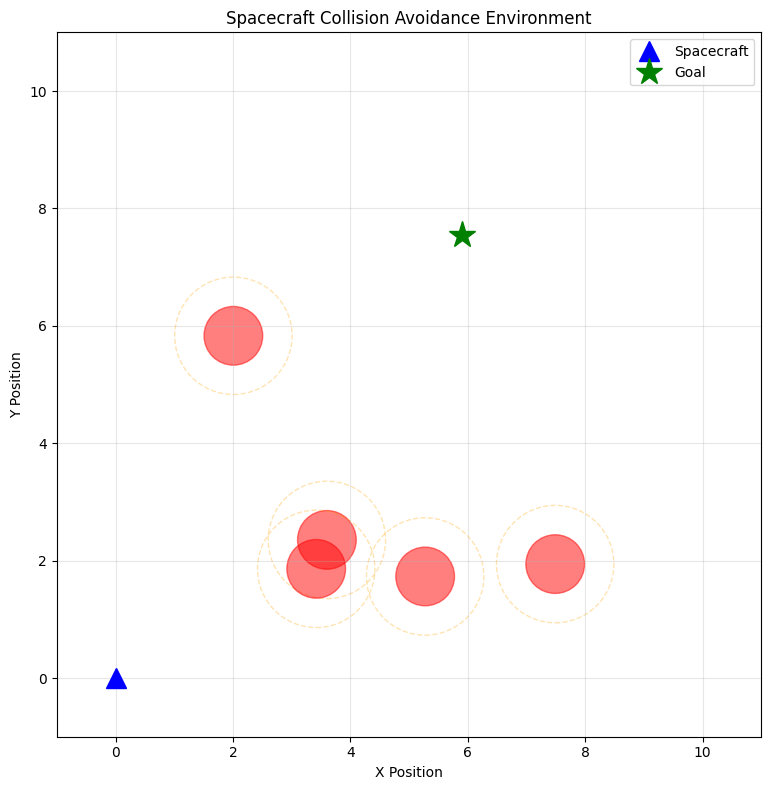

In [ ]:
# Create and test the environment
env = SpacecraftEnv(num_obstacles=5)
obs, info = env.reset(seed=42)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Initial observation:", obs)

# Visualize initial state
fig = env.render()
plt.show()

## Train PPO Agent

Now we'll train a PPO agent to navigate the spacecraft.

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import time

class TrainingCallback(BaseCallback):
    """Custom callback for tracking training progress"""
    def __init__(self, check_freq=1000, verbose=1):
        super(TrainingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self):
        # Log episode data
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                self.episode_rewards.append(info['r'])
                self.episode_lengths.append(info['l'])
        return True

    def _on_rollout_end(self):
        if self.verbose > 0 and len(self.episode_rewards) > 0:
            mean_reward = np.mean(self.episode_rewards[-100:])
            print(f"Steps: {self.num_timesteps}, Mean Reward (last 100 ep): {mean_reward:.2f}")

# Create training environment
train_env = SpacecraftEnv(num_obstacles=5)

# Create PPO model
print("Creating PPO model...")
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    tensorboard_log="./ppo_spacecraft_tensorboard/"
)

# Create callback
callback = TrainingCallback(check_freq=1000, verbose=1)

# Train the model
print("\nStarting training...")
start_time = time.time()
model.learn(total_timesteps=100000, callback=callback, progress_bar=True)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds")
model.save("ppo_spacecraft_model")
print("Model saved!")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Creating PPO model...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Starting training...
Logging to ./ppo_spacecraft_tensorboard/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Steps: 2048, Mean Reward (last 100 ep): -244.48

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 194      |
|    ep_rew_mean     | -244     |
| time/              |          |
|    fps             | 1065     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


Steps: 4096, Mean Reward (last 100 ep): -234.24

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 181          |
|    ep_rew_mean          | -235         |
| time/                   |              |
|    fps                  | 782          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0043970575 |
|    clip_fraction        | 0.0247       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00958     |
|    learning_rate        | 0.0003       |
|    loss                 | 45.3         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00424     |
|    std                  | 0.996        |
|    value_loss           | 183          |
------------------------------------------


Steps: 6144, Mean Reward (last 100 ep): -230.66

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 173          |
|    ep_rew_mean          | -231         |
| time/                   |              |
|    fps                  | 648          |
|    iterations           | 3            |
|    time_elapsed         | 9            |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0035497928 |
|    clip_fraction        | 0.0314       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00205      |
|    learning_rate        | 0.0003       |
|    loss                 | 88           |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00361     |
|    std                  | 0.996        |
|    value_loss           | 271          |
------------------------------------------


Steps: 8192, Mean Reward (last 100 ep): -218.51

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 167         |
|    ep_rew_mean          | -217        |
| time/                   |             |
|    fps                  | 639         |
|    iterations           | 4           |
|    time_elapsed         | 12          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.005893928 |
|    clip_fraction        | 0.0508      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.00127    |
|    learning_rate        | 0.0003      |
|    loss                 | 80.7        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00464    |
|    std                  | 1           |
|    value_loss           | 253         |
-----------------------------------------


Steps: 10240, Mean Reward (last 100 ep): -204.52

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 166          |
|    ep_rew_mean          | -210         |
| time/                   |              |
|    fps                  | 638          |
|    iterations           | 5            |
|    time_elapsed         | 16           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0075044194 |
|    clip_fraction        | 0.0607       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.000298     |
|    learning_rate        | 0.0003       |
|    loss                 | 51           |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00599     |
|    std                  | 0.996        |
|    value_loss           | 156          |
------------------------------------------


Steps: 12288, Mean Reward (last 100 ep): -192.73

Steps: 14336, Mean Reward (last 100 ep): -186.93

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 148          |
|    ep_rew_mean          | -190         |
| time/                   |              |
|    fps                  | 605          |
|    iterations           | 7            |
|    time_elapsed         | 23           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0061334195 |
|    clip_fraction        | 0.049        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00151      |
|    learning_rate        | 0.0003       |
|    loss                 | 21.9         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00632     |
|    std                  | 0.993        |
|    value_loss           | 87.6         |
------------------------------------------


Steps: 16384, Mean Reward (last 100 ep): -178.68

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 140         |
|    ep_rew_mean          | -179        |
| time/                   |             |
|    fps                  | 605         |
|    iterations           | 8           |
|    time_elapsed         | 27          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.005671221 |
|    clip_fraction        | 0.0505      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.000702    |
|    learning_rate        | 0.0003      |
|    loss                 | 20.7        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0045     |
|    std                  | 1.01        |
|    value_loss           | 129         |
-----------------------------------------


Steps: 18432, Mean Reward (last 100 ep): -170.03

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 136          |
|    ep_rew_mean          | -170         |
| time/                   |              |
|    fps                  | 606          |
|    iterations           | 9            |
|    time_elapsed         | 30           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0045456146 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.0645       |
|    learning_rate        | 0.0003       |
|    loss                 | 85.6         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00504     |
|    std                  | 1.01         |
|    value_loss           | 157          |
------------------------------------------


Steps: 20480, Mean Reward (last 100 ep): -153.98

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 123         |
|    ep_rew_mean          | -154        |
| time/                   |             |
|    fps                  | 594         |
|    iterations           | 10          |
|    time_elapsed         | 34          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.008941444 |
|    clip_fraction        | 0.0737      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.88       |
|    explained_variance   | 0.186       |
|    learning_rate        | 0.0003      |
|    loss                 | 29.8        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00802    |
|    std                  | 1.03        |
|    value_loss           | 82.6        |
-----------------------------------------


Steps: 22528, Mean Reward (last 100 ep): -136.65

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 109          |
|    ep_rew_mean          | -137         |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 11           |
|    time_elapsed         | 37           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0071341405 |
|    clip_fraction        | 0.0608       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.89        |
|    explained_variance   | 0.188        |
|    learning_rate        | 0.0003       |
|    loss                 | 63.4         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00587     |
|    std                  | 1.02         |
|    value_loss           | 144          |
------------------------------------------


Steps: 24576, Mean Reward (last 100 ep): -130.28

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 104        |
|    ep_rew_mean          | -130       |
| time/                   |            |
|    fps                  | 594        |
|    iterations           | 12         |
|    time_elapsed         | 41         |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.00617122 |
|    clip_fraction        | 0.0457     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88      |
|    explained_variance   | 0.478      |
|    learning_rate        | 0.0003     |
|    loss                 | 99.8       |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.0038    |
|    std                  | 1.02       |
|    value_loss           | 103        |
----------------------------------------


Steps: 26624, Mean Reward (last 100 ep): -108.55

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 85.3         |
|    ep_rew_mean          | -109         |
| time/                   |              |
|    fps                  | 594          |
|    iterations           | 13           |
|    time_elapsed         | 44           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0050317063 |
|    clip_fraction        | 0.0155       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.33         |
|    learning_rate        | 0.0003       |
|    loss                 | 141          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00304     |
|    std                  | 1.02         |
|    value_loss           | 135          |
------------------------------------------


Steps: 28672, Mean Reward (last 100 ep): -98.73

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 72.2         |
|    ep_rew_mean          | -98.7        |
| time/                   |              |
|    fps                  | 586          |
|    iterations           | 14           |
|    time_elapsed         | 48           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0040668487 |
|    clip_fraction        | 0.0247       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.491        |
|    learning_rate        | 0.0003       |
|    loss                 | 44.2         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00462     |
|    std                  | 1.02         |
|    value_loss           | 108          |
------------------------------------------


Steps: 30720, Mean Reward (last 100 ep): -89.60

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59.1        |
|    ep_rew_mean          | -89.6       |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 15          |
|    time_elapsed         | 52          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.004264445 |
|    clip_fraction        | 0.0248      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.88       |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.0003      |
|    loss                 | 100         |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00449    |
|    std                  | 1.02        |
|    value_loss           | 219         |
-----------------------------------------


Steps: 32768, Mean Reward (last 100 ep): -81.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 56.1        |
|    ep_rew_mean          | -81         |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 16          |
|    time_elapsed         | 55          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.005948631 |
|    clip_fraction        | 0.0226      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.88       |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 65.8        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00317    |
|    std                  | 1.02        |
|    value_loss           | 177         |
-----------------------------------------


Steps: 34816, Mean Reward (last 100 ep): -85.34

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 60.2         |
|    ep_rew_mean          | -85.3        |
| time/                   |              |
|    fps                  | 587          |
|    iterations           | 17           |
|    time_elapsed         | 59           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0032721697 |
|    clip_fraction        | 0.00796      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.87        |
|    explained_variance   | 0.149        |
|    learning_rate        | 0.0003       |
|    loss                 | 33.9         |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00268     |
|    std                  | 1.02         |
|    value_loss           | 325          |
------------------------------------------


Steps: 36864, Mean Reward (last 100 ep): -85.25

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 62.9         |
|    ep_rew_mean          | -85.3        |
| time/                   |              |
|    fps                  | 585          |
|    iterations           | 18           |
|    time_elapsed         | 62           |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0038839714 |
|    clip_fraction        | 0.03         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.87        |
|    explained_variance   | 0.284        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.07         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00336     |
|    std                  | 1.02         |
|    value_loss           | 85.2         |
------------------------------------------


Steps: 38912, Mean Reward (last 100 ep): -87.68

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 64.8        |
|    ep_rew_mean          | -87.7       |
| time/                   |             |
|    fps                  | 587         |
|    iterations           | 19          |
|    time_elapsed         | 66          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.005232062 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0.164       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.7        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00467    |
|    std                  | 1.02        |
|    value_loss           | 173         |
-----------------------------------------


Steps: 40960, Mean Reward (last 100 ep): -86.07

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 62.8        |
|    ep_rew_mean          | -86.1       |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 20          |
|    time_elapsed         | 69          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.004336319 |
|    clip_fraction        | 0.0243      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.4        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00624    |
|    std                  | 1.01        |
|    value_loss           | 160         |
-----------------------------------------


Steps: 43008, Mean Reward (last 100 ep): -86.09

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59.2        |
|    ep_rew_mean          | -86.1       |
| time/                   |             |
|    fps                  | 583         |
|    iterations           | 21          |
|    time_elapsed         | 73          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.008562944 |
|    clip_fraction        | 0.0521      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.86       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.8        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00609    |
|    std                  | 1.01        |
|    value_loss           | 107         |
-----------------------------------------


Steps: 45056, Mean Reward (last 100 ep): -82.05

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 58.2         |
|    ep_rew_mean          | -82          |
| time/                   |              |
|    fps                  | 584          |
|    iterations           | 22           |
|    time_elapsed         | 77           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0052134753 |
|    clip_fraction        | 0.0233       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.86        |
|    explained_variance   | 0.0395       |
|    learning_rate        | 0.0003       |
|    loss                 | 12.9         |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00253     |
|    std                  | 1.02         |
|    value_loss           | 194          |
------------------------------------------


Steps: 47104, Mean Reward (last 100 ep): -83.85

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59.3        |
|    ep_rew_mean          | -83.9       |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 23          |
|    time_elapsed         | 80          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.005782863 |
|    clip_fraction        | 0.0586      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.86       |
|    explained_variance   | 0.225       |
|    learning_rate        | 0.0003      |
|    loss                 | 35.8        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00511    |
|    std                  | 1.01        |
|    value_loss           | 271         |
-----------------------------------------


Steps: 49152, Mean Reward (last 100 ep): -84.29

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 61.9         |
|    ep_rew_mean          | -84.3        |
| time/                   |              |
|    fps                  | 575          |
|    iterations           | 24           |
|    time_elapsed         | 85           |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0040145963 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.86        |
|    explained_variance   | 0.186        |
|    learning_rate        | 0.0003       |
|    loss                 | 27.1         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00612     |
|    std                  | 1.01         |
|    value_loss           | 146          |
------------------------------------------


Steps: 51200, Mean Reward (last 100 ep): -79.18

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 65.3        |
|    ep_rew_mean          | -79.2       |
| time/                   |             |
|    fps                  | 575         |
|    iterations           | 25          |
|    time_elapsed         | 88          |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.005047423 |
|    clip_fraction        | 0.0471      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.0003      |
|    loss                 | 55.8        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0064     |
|    std                  | 1           |
|    value_loss           | 145         |
-----------------------------------------


Steps: 53248, Mean Reward (last 100 ep): -78.30

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 68           |
|    ep_rew_mean          | -78.3        |
| time/                   |              |
|    fps                  | 576          |
|    iterations           | 26           |
|    time_elapsed         | 92           |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0040260702 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.191        |
|    learning_rate        | 0.0003       |
|    loss                 | 59.3         |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00434     |
|    std                  | 1            |
|    value_loss           | 397          |
------------------------------------------


Steps: 55296, Mean Reward (last 100 ep): -80.13

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 76.2         |
|    ep_rew_mean          | -80.1        |
| time/                   |              |
|    fps                  | 576          |
|    iterations           | 27           |
|    time_elapsed         | 95           |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0057009947 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.244        |
|    learning_rate        | 0.0003       |
|    loss                 | 15           |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00667     |
|    std                  | 1            |
|    value_loss           | 170          |
------------------------------------------


Steps: 57344, Mean Reward (last 100 ep): -77.14

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 77.2        |
|    ep_rew_mean          | -77.1       |
| time/                   |             |
|    fps                  | 572         |
|    iterations           | 28          |
|    time_elapsed         | 100         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.009913601 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.8        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00621    |
|    std                  | 1.01        |
|    value_loss           | 73          |
-----------------------------------------


Steps: 59392, Mean Reward (last 100 ep): -79.55

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 83.7        |
|    ep_rew_mean          | -79.6       |
| time/                   |             |
|    fps                  | 573         |
|    iterations           | 29          |
|    time_elapsed         | 103         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.006383204 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.265       |
|    learning_rate        | 0.0003      |
|    loss                 | 56          |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00841    |
|    std                  | 1.01        |
|    value_loss           | 212         |
-----------------------------------------


Steps: 61440, Mean Reward (last 100 ep): -77.77

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 84.3        |
|    ep_rew_mean          | -77.8       |
| time/                   |             |
|    fps                  | 573         |
|    iterations           | 30          |
|    time_elapsed         | 107         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.011075705 |
|    clip_fraction        | 0.0847      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.86       |
|    explained_variance   | 0.177       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.1        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00884    |
|    std                  | 1.01        |
|    value_loss           | 148         |
-----------------------------------------


Steps: 63488, Mean Reward (last 100 ep): -77.24

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 80.1         |
|    ep_rew_mean          | -77.2        |
| time/                   |              |
|    fps                  | 571          |
|    iterations           | 31           |
|    time_elapsed         | 111          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0049883127 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.86        |
|    explained_variance   | 0.328        |
|    learning_rate        | 0.0003       |
|    loss                 | 63           |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.0058      |
|    std                  | 1.01         |
|    value_loss           | 223          |
------------------------------------------


Steps: 65536, Mean Reward (last 100 ep): -78.15

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 76.9        |
|    ep_rew_mean          | -78.1       |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 32          |
|    time_elapsed         | 114         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.009852093 |
|    clip_fraction        | 0.0493      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.86       |
|    explained_variance   | 0.339       |
|    learning_rate        | 0.0003      |
|    loss                 | 80.7        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.007      |
|    std                  | 1.01        |
|    value_loss           | 201         |
-----------------------------------------


Steps: 67584, Mean Reward (last 100 ep): -77.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 69.3        |
|    ep_rew_mean          | -77         |
| time/                   |             |
|    fps                  | 571         |
|    iterations           | 33          |
|    time_elapsed         | 118         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.004619617 |
|    clip_fraction        | 0.0317      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.6        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0045     |
|    std                  | 1.02        |
|    value_loss           | 142         |
-----------------------------------------


Steps: 69632, Mean Reward (last 100 ep): -77.12

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 75           |
|    ep_rew_mean          | -77.1        |
| time/                   |              |
|    fps                  | 570          |
|    iterations           | 34           |
|    time_elapsed         | 122          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0055388566 |
|    clip_fraction        | 0.0382       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.266        |
|    learning_rate        | 0.0003       |
|    loss                 | 19           |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00688     |
|    std                  | 1.01         |
|    value_loss           | 192          |
------------------------------------------


Steps: 71680, Mean Reward (last 100 ep): -80.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 79.6         |
|    ep_rew_mean          | -80          |
| time/                   |              |
|    fps                  | 567          |
|    iterations           | 35           |
|    time_elapsed         | 126          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0066589946 |
|    clip_fraction        | 0.0609       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.87        |
|    explained_variance   | 0.333        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.1         |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00583     |
|    std                  | 1.01         |
|    value_loss           | 178          |
------------------------------------------


Steps: 73728, Mean Reward (last 100 ep): -77.12

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 76.5        |
|    ep_rew_mean          | -77.1       |
| time/                   |             |
|    fps                  | 567         |
|    iterations           | 36          |
|    time_elapsed         | 129         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.008758726 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0.418       |
|    learning_rate        | 0.0003      |
|    loss                 | 55.1        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00541    |
|    std                  | 1.02        |
|    value_loss           | 138         |
-----------------------------------------


Steps: 75776, Mean Reward (last 100 ep): -77.57

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 85.8         |
|    ep_rew_mean          | -77.6        |
| time/                   |              |
|    fps                  | 568          |
|    iterations           | 37           |
|    time_elapsed         | 133          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0056555197 |
|    clip_fraction        | 0.0433       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.42         |
|    learning_rate        | 0.0003       |
|    loss                 | 76           |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00548     |
|    std                  | 1.02         |
|    value_loss           | 199          |
------------------------------------------


Steps: 77824, Mean Reward (last 100 ep): -79.00

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 90.3         |
|    ep_rew_mean          | -79          |
| time/                   |              |
|    fps                  | 566          |
|    iterations           | 38           |
|    time_elapsed         | 137          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0061505367 |
|    clip_fraction        | 0.0581       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.399        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.16         |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.0062      |
|    std                  | 1.02         |
|    value_loss           | 112          |
------------------------------------------
-----------------------------------------
| rollout/  

Steps: 81920, Mean Reward (last 100 ep): -79.62

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 87.8        |
|    ep_rew_mean          | -79.6       |
| time/                   |             |
|    fps                  | 568         |
|    iterations           | 40          |
|    time_elapsed         | 144         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.007947878 |
|    clip_fraction        | 0.0724      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0.306       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.5        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00749    |
|    std                  | 1.02        |
|    value_loss           | 183         |
-----------------------------------------


Steps: 83968, Mean Reward (last 100 ep): -81.71

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 76.5         |
|    ep_rew_mean          | -81.7        |
| time/                   |              |
|    fps                  | 567          |
|    iterations           | 41           |
|    time_elapsed         | 147          |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0070662703 |
|    clip_fraction        | 0.0706       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | 0.161        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.3         |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.00614     |
|    std                  | 1.02         |
|    value_loss           | 196          |
------------------------------------------


Steps: 86016, Mean Reward (last 100 ep): -70.22

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 61.8         |
|    ep_rew_mean          | -70.2        |
| time/                   |              |
|    fps                  | 566          |
|    iterations           | 42           |
|    time_elapsed         | 151          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0055980375 |
|    clip_fraction        | 0.0422       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.89        |
|    explained_variance   | 0.357        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.3         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00681     |
|    std                  | 1.03         |
|    value_loss           | 213          |
------------------------------------------


Steps: 88064, Mean Reward (last 100 ep): -66.48

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52.5        |
|    ep_rew_mean          | -66.5       |
| time/                   |             |
|    fps                  | 567         |
|    iterations           | 43          |
|    time_elapsed         | 155         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.007662695 |
|    clip_fraction        | 0.0598      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.9        |
|    explained_variance   | 0.372       |
|    learning_rate        | 0.0003      |
|    loss                 | 49          |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00768    |
|    std                  | 1.03        |
|    value_loss           | 296         |
-----------------------------------------


Steps: 90112, Mean Reward (last 100 ep): -69.16

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55          |
|    ep_rew_mean          | -69.2       |
| time/                   |             |
|    fps                  | 569         |
|    iterations           | 44          |
|    time_elapsed         | 158         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.009262092 |
|    clip_fraction        | 0.0746      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.91       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.3        |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.00814    |
|    std                  | 1.04        |
|    value_loss           | 159         |
-----------------------------------------


Steps: 92160, Mean Reward (last 100 ep): -71.98

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 66.4         |
|    ep_rew_mean          | -72          |
| time/                   |              |
|    fps                  | 567          |
|    iterations           | 45           |
|    time_elapsed         | 162          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0064906683 |
|    clip_fraction        | 0.049        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.91        |
|    explained_variance   | 0.14         |
|    learning_rate        | 0.0003       |
|    loss                 | 78.4         |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.005       |
|    std                  | 1.04         |
|    value_loss           | 247          |
------------------------------------------


Steps: 94208, Mean Reward (last 100 ep): -72.40

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 56.5        |
|    ep_rew_mean          | -72.4       |
| time/                   |             |
|    fps                  | 568         |
|    iterations           | 46          |
|    time_elapsed         | 165         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.006269344 |
|    clip_fraction        | 0.0536      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.91       |
|    explained_variance   | 0.559       |
|    learning_rate        | 0.0003      |
|    loss                 | 91.2        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00692    |
|    std                  | 1.04        |
|    value_loss           | 190         |
-----------------------------------------


Steps: 96256, Mean Reward (last 100 ep): -72.37

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 60.4        |
|    ep_rew_mean          | -72.4       |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 47          |
|    time_elapsed         | 168         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.006310453 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.91       |
|    explained_variance   | 0.367       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.7        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00648    |
|    std                  | 1.04        |
|    value_loss           | 147         |
-----------------------------------------


Steps: 98304, Mean Reward (last 100 ep): -75.23

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 61.5       |
|    ep_rew_mean          | -75.2      |
| time/                   |            |
|    fps                  | 570        |
|    iterations           | 48         |
|    time_elapsed         | 172        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.00729302 |
|    clip_fraction        | 0.0567     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.91      |
|    explained_variance   | 0.529      |
|    learning_rate        | 0.0003     |
|    loss                 | 65.4       |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.00545   |
|    std                  | 1.04       |
|    value_loss           | 154        |
----------------------------------------


Steps: 100352, Mean Reward (last 100 ep): -70.23

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 70          |
|    ep_rew_mean          | -70.2       |
| time/                   |             |
|    fps                  | 568         |
|    iterations           | 49          |
|    time_elapsed         | 176         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.009785542 |
|    clip_fraction        | 0.0816      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.91       |
|    explained_variance   | 0.166       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.8        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00694    |
|    std                  | 1.04        |
|    value_loss           | 116         |
-----------------------------------------



Training completed in 177.81 seconds
Model saved!


## Visualize Training Progress

Let's plot the training rewards over time.

/tmp/ipython-input-935958416.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


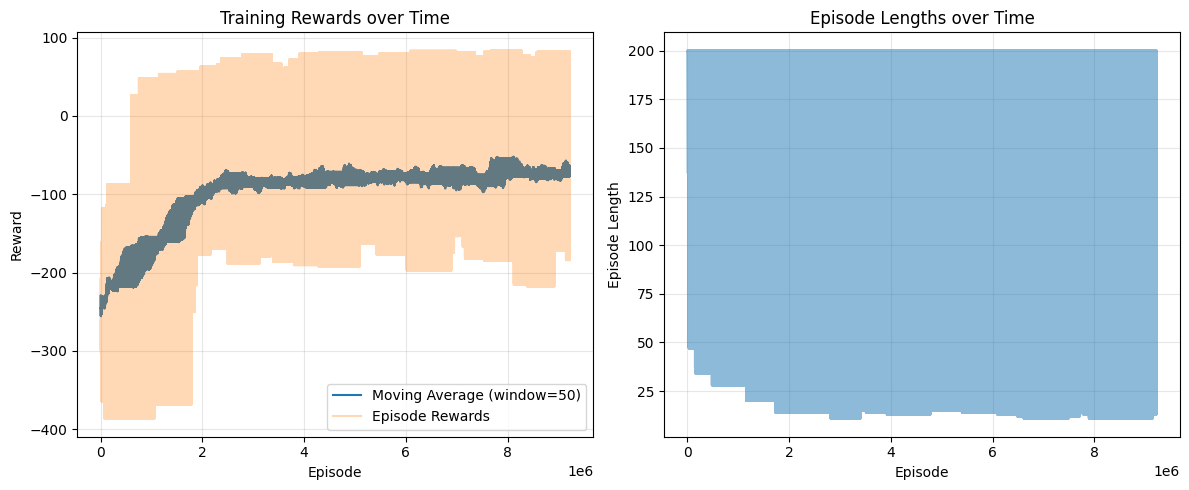


Training Statistics:
Total Episodes: 9223505
Mean Reward (last 100): -70.23
Max Reward: 83.31
Mean Episode Length: 82.79


In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot rewards
plt.subplot(1, 2, 1)
if len(callback.episode_rewards) > 0:
    # Calculate moving average
    window = 50
    if len(callback.episode_rewards) >= window:
        moving_avg = np.convolve(callback.episode_rewards,
                                np.ones(window)/window, mode='valid')
        plt.plot(moving_avg, label=f'Moving Average (window={window})')
    plt.plot(callback.episode_rewards, alpha=0.3, label='Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot episode lengths
plt.subplot(1, 2, 2)
if len(callback.episode_lengths) > 0:
    plt.plot(callback.episode_lengths, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')
    plt.title('Episode Lengths over Time')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if len(callback.episode_rewards) > 0:
    print(f"\nTraining Statistics:")
    print(f"Total Episodes: {len(callback.episode_rewards)}")
    print(f"Mean Reward (last 100): {np.mean(callback.episode_rewards[-100:]):.2f}")
    print(f"Max Reward: {np.max(callback.episode_rewards):.2f}")
    print(f"Mean Episode Length: {np.mean(callback.episode_lengths):.2f}")

## Evaluate Trained Agent

Let's test the trained agent in multiple episodes.

In [ ]:
# Evaluate the trained agent
num_eval_episodes = 10
eval_env = SpacecraftEnv(num_obstacles=5)

episode_rewards = []
episode_lengths = []
successes = 0

for episode in range(num_eval_episodes):
    obs, info = eval_env.reset()
    done = False
    episode_reward = 0
    steps = 0

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        episode_reward += reward
        steps += 1

    episode_rewards.append(episode_reward)
    episode_lengths.append(steps)

    # Check if successfully reached goal
    dist_to_goal = np.linalg.norm(eval_env.spacecraft_pos - eval_env.goal_pos)
    if dist_to_goal < 0.5:
        successes += 1

    print(f"Episode {episode+1}: Reward = {episode_reward:.2f}, Steps = {steps}, Success = {dist_to_goal < 0.5}")

print(f"\nEvaluation Results:")
print(f"Mean Reward: {np.mean(episode_rewards):.2f} +/- {np.std(episode_rewards):.2f}")
print(f"Mean Episode Length: {np.mean(episode_lengths):.2f}")
print(f"Success Rate: {successes}/{num_eval_episodes} ({successes/num_eval_episodes*100:.1f}%)")

Episode 1: Reward = -87.65, Steps = 200, Success = False
Episode 2: Reward = -82.95, Steps = 30, Success = False
Episode 3: Reward = -88.87, Steps = 200, Success = False
Episode 4: Reward = -77.32, Steps = 30, Success = False
Episode 5: Reward = -63.59, Steps = 11, Success = False
Episode 6: Reward = -68.05, Steps = 23, Success = False
Episode 7: Reward = -125.14, Steps = 111, Success = False
Episode 8: Reward = -108.83, Steps = 200, Success = False
Episode 9: Reward = -85.17, Steps = 26, Success = False
Episode 10: Reward = -80.54, Steps = 26, Success = False

Evaluation Results:
Mean Reward: -86.81 +/- 17.31
Mean Episode Length: 85.70
Success Rate: 0/10 (0.0%)


## Visualize Agent Trajectory

Let's visualize how the trained agent navigates through the environment.

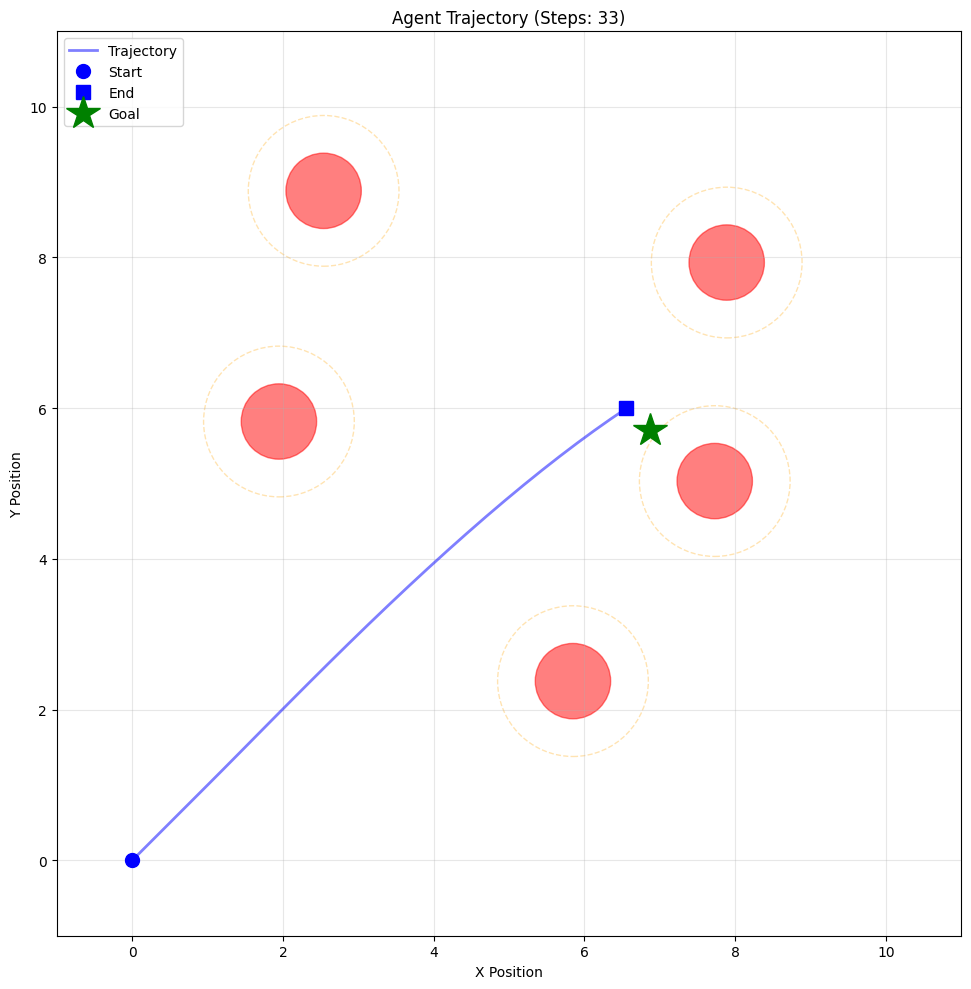

✓ Successfully reached goal!


In [ ]:
# Visualize a single episode with trajectory
test_env = SpacecraftEnv(num_obstacles=5)
obs, info = test_env.reset(seed=123)

trajectory = [test_env.spacecraft_pos.copy()]
done = False
step_count = 0

while not done and step_count < 200:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    trajectory.append(test_env.spacecraft_pos.copy())
    step_count += 1

trajectory = np.array(trajectory)

# Plot the trajectory
fig, ax = plt.subplots(figsize=(10, 10))

# Plot boundaries
ax.set_xlim(-1, test_env.space_size + 1)
ax.set_ylim(-1, test_env.space_size + 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Plot trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', alpha=0.5, linewidth=2, label='Trajectory')
ax.plot(trajectory[0, 0], trajectory[0, 1], 'bo', markersize=10, label='Start')
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'bs', markersize=10, label='End')

# Plot goal
ax.plot(test_env.goal_pos[0], test_env.goal_pos[1], 'g*', markersize=25, label='Goal')

# Plot obstacles
for obstacle in test_env.obstacles:
    circle = Circle(obstacle, 0.5, color='red', alpha=0.5)
    ax.add_patch(circle)
    danger_circle = Circle(obstacle, 1.0, color='orange', fill=False, linestyle='--', alpha=0.3)
    ax.add_patch(danger_circle)

ax.legend(loc='upper left')
ax.set_title(f'Agent Trajectory (Steps: {step_count})')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

plt.tight_layout()
plt.show()

# Check success
dist_to_goal = np.linalg.norm(test_env.spacecraft_pos - test_env.goal_pos)
if dist_to_goal < 0.5:
    print("✓ Successfully reached goal!")
else:
    print(f"✗ Did not reach goal. Final distance: {dist_to_goal:.2f}")

## Successful Navigation Visualization

✓ Success! Found successful navigation on attempt 9 with seed 8505
  Steps taken: 77
  Final distance to goal: 0.48


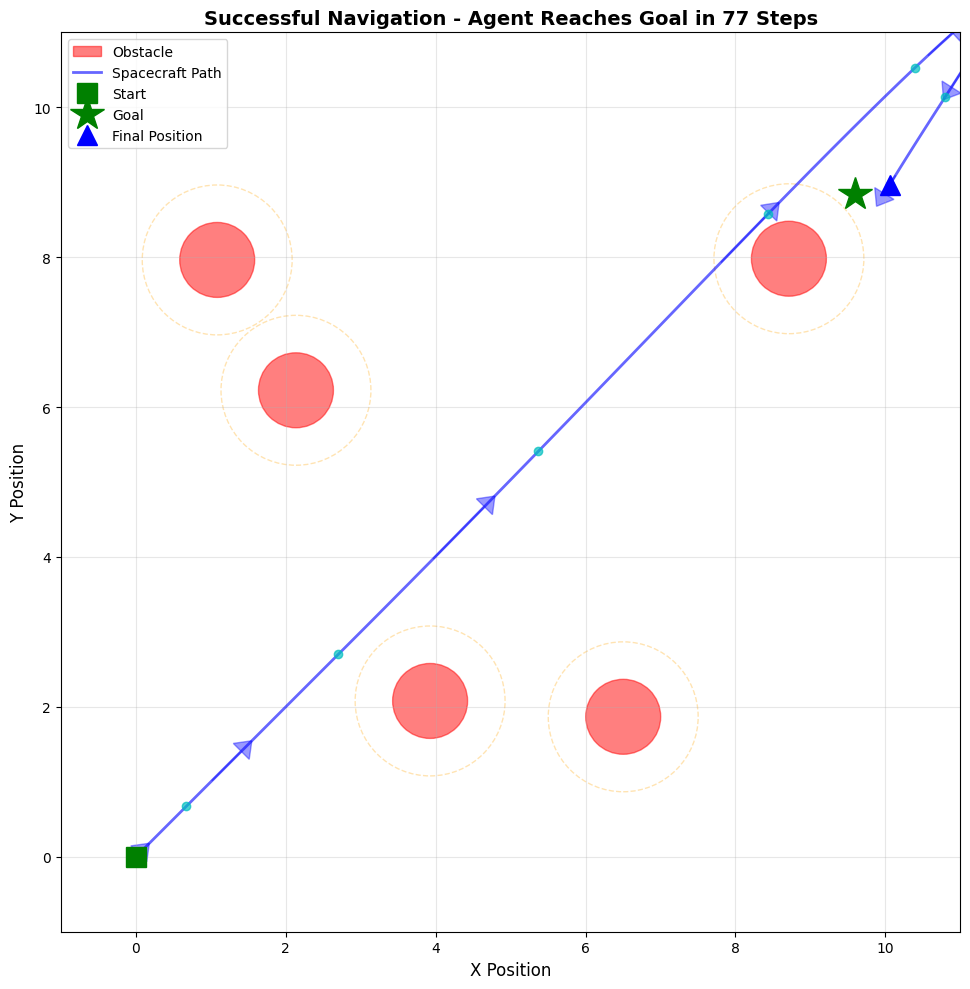

In [ ]:
# Visualize a successful navigation scenario
# We'll run multiple attempts until we get a successful one
import random

max_attempts = 100
success_found = False

for attempt in range(max_attempts):
    seed_val = random.randint(1, 10000)
    test_env = SpacecraftEnv(num_obstacles=5)
    obs, info = test_env.reset(seed=seed_val)
    trajectory = [test_env.spacecraft_pos.copy()]
    done = False
    step_count = 0

    while not done and step_count < 200:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        trajectory.append(test_env.spacecraft_pos.copy())
        step_count += 1

    # Check if reached goal
    dist_to_goal = np.linalg.norm(test_env.spacecraft_pos - test_env.goal_pos)
    if dist_to_goal < 0.5:
        success_found = True
        print(f"✓ Success! Found successful navigation on attempt {attempt+1} with seed {seed_val}")
        print(f"  Steps taken: {step_count}")
        print(f"  Final distance to goal: {dist_to_goal:.2f}")

        # Visualize the successful trajectory
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plot boundaries
        ax.set_xlim(-1, test_env.space_size + 1)
        ax.set_ylim(-1, test_env.space_size + 1)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)

        # Plot obstacles
        for obstacle in test_env.obstacles:
            circle = Circle(obstacle, 0.5, color='red', alpha=0.5, label='Obstacle' if obstacle is test_env.obstacles[0] else '')
            ax.add_patch(circle)
            danger_circle = Circle(obstacle, 1.0, color='orange', fill=False, linestyle='--', alpha=0.3)
            ax.add_patch(danger_circle)

        # Plot trajectory as a path
        trajectory_array = np.array(trajectory)
        ax.plot(trajectory_array[:, 0], trajectory_array[:, 1],
                'b-', linewidth=2, alpha=0.6, label='Spacecraft Path')

        # Plot waypoints along trajectory
        step_markers = np.linspace(0, len(trajectory)-1, min(10, len(trajectory)), dtype=int)
        for i, idx in enumerate(step_markers):
            ax.plot(trajectory_array[idx, 0], trajectory_array[idx, 1],
                    'co', markersize=6, alpha=0.7)

        # Plot start position
        ax.plot(trajectory_array[0, 0], trajectory_array[0, 1],
                'gs', markersize=15, label='Start', zorder=5)

        # Plot goal
        ax.plot(test_env.goal_pos[0], test_env.goal_pos[1],
                'g*', markersize=25, label='Goal', zorder=5)

        # Plot final position
        ax.plot(trajectory_array[-1, 0], trajectory_array[-1, 1],
                'b^', markersize=15, label='Final Position', zorder=5)

        # Add velocity vectors at select points
        num_arrows = 8
        arrow_indices = np.linspace(0, len(trajectory)-2, num_arrows, dtype=int)
        for idx in arrow_indices:
            if idx < len(trajectory) - 1:
                dx = trajectory_array[idx+1, 0] - trajectory_array[idx, 0]
                dy = trajectory_array[idx+1, 1] - trajectory_array[idx, 1]
                ax.arrow(trajectory_array[idx, 0], trajectory_array[idx, 1],
                        dx*2, dy*2, head_width=0.3, head_length=0.2,
                        fc='blue', ec='blue', alpha=0.4)

        ax.legend(loc='upper left', fontsize=10)
        ax.set_title(f'Successful Navigation - Agent Reaches Goal in {step_count} Steps',
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('X Position', fontsize=12)
        ax.set_ylabel('Y Position', fontsize=12)

        plt.tight_layout()
        plt.show()
        break

if not success_found:
    print(f"No successful navigation found in {max_attempts} attempts.")
    print("Training may need more timesteps or hyperparameter tuning.")

## Data Analytics: Before vs After Training

DATA ANALYTICS: BEFORE VS AFTER TRAINING

[1/3] Evaluating baseline random agent...
Baseline completed: 100 episodes

[2/3] Evaluating trained PPO agent...
Trained agent completed: 100 episodes

[3/3] Computing statistics and visualizations...

PERFORMANCE COMPARISON

Metric                    | Random Baseline | Trained Agent | Improvement
--------------------------------------------------------------------------------
Success Rate (%)          |            0.00 |         13.00 | +13.00
Collision Rate (%)        |            8.00 |         59.00 | +51.00
Mean Reward               |         -259.44 |        -64.67 | +75.1%
Mean Episode Length       |          193.31 |         77.96 | +59.7%
Mean Final Distance       |           13.56 |          3.64 | +73.2%


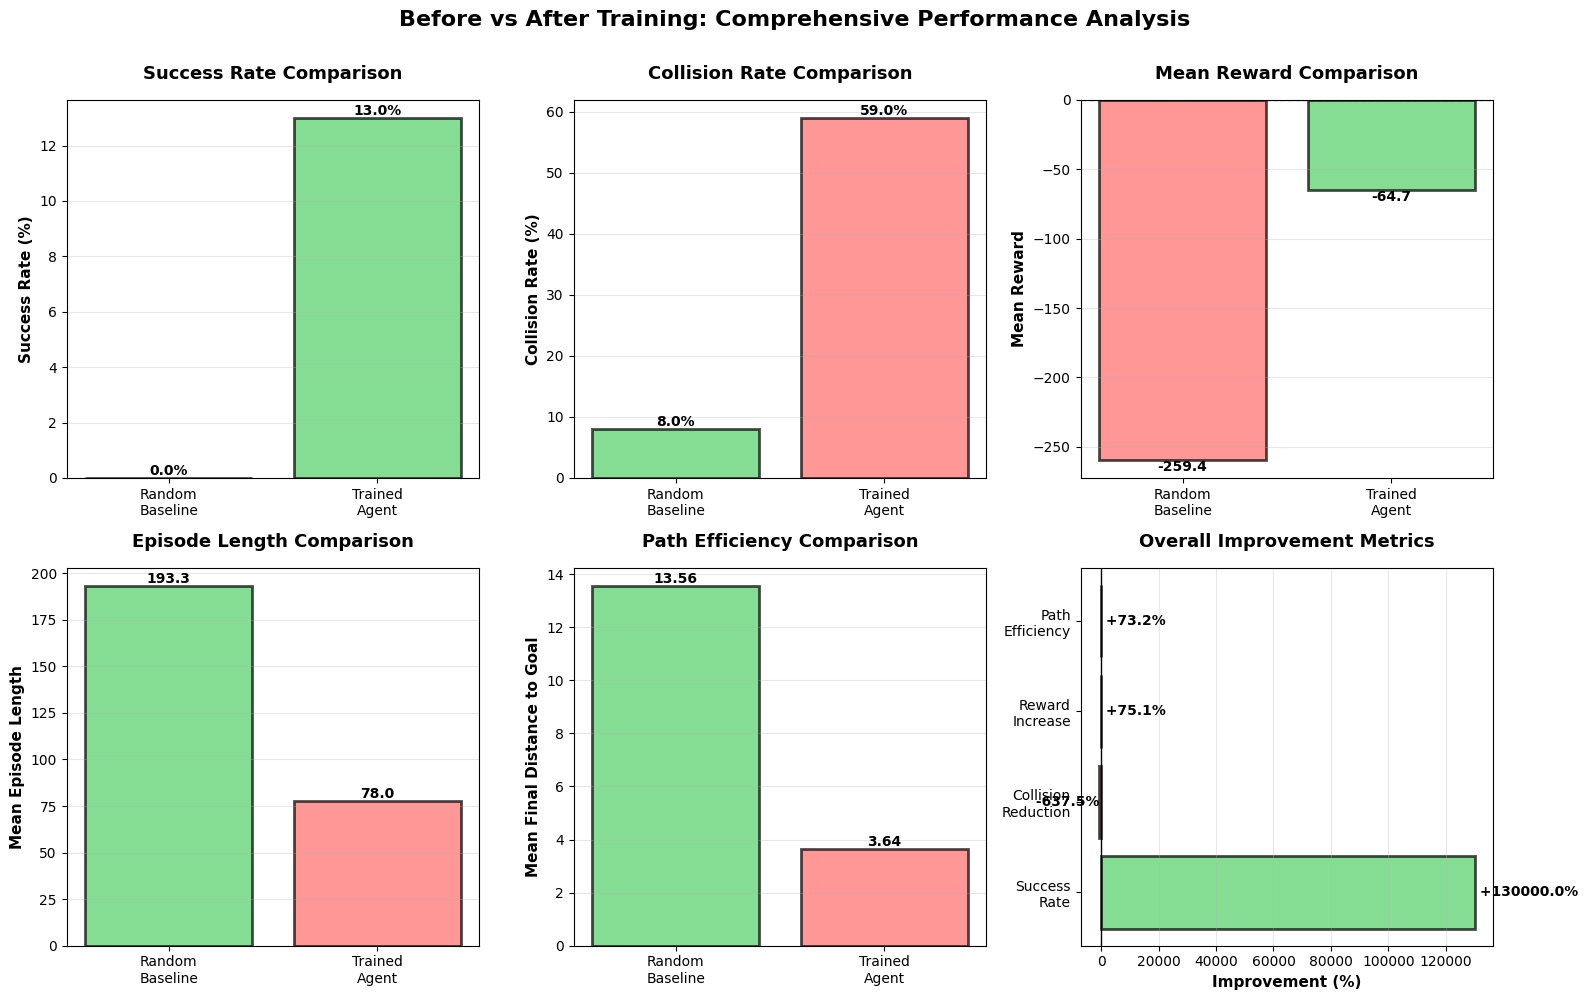


ANALYSIS COMPLETE


In [ ]:
# Data Analytics: Before vs After Training
# This section compares the performance of a random baseline agent with the trained PPO agent

print("=" * 80)
print("DATA ANALYTICS: BEFORE VS AFTER TRAINING")
print("=" * 80)

# 1. Baseline Random Agent Performance
print("\n[1/3] Evaluating baseline random agent...")
num_baseline_episodes = 100
baseline_env = SpacecraftEnv(num_obstacles=5)

baseline_rewards = []
baseline_lengths = []
baseline_successes = 0
baseline_collisions = 0
baseline_distances = []

for episode in range(num_baseline_episodes):
    obs, info = baseline_env.reset()
    done = False
    episode_reward = 0
    steps = 0

    while not done and steps < 200:
        # Random action
        action = baseline_env.action_space.sample()
        obs, reward, terminated, truncated, info = baseline_env.step(action)
        done = terminated or truncated
        episode_reward += reward
        steps += 1

    baseline_rewards.append(episode_reward)
    baseline_lengths.append(steps)

    # Check success/collision
    dist_to_goal = np.linalg.norm(baseline_env.spacecraft_pos - baseline_env.goal_pos)
    baseline_distances.append(dist_to_goal)
    if dist_to_goal < 0.5:
        baseline_successes += 1

    # Check collision
    for obstacle in baseline_env.obstacles:
        if np.linalg.norm(baseline_env.spacecraft_pos - obstacle) < 0.5:
            baseline_collisions += 1
            break

print(f"Baseline completed: {num_baseline_episodes} episodes")

# 2. Trained Agent Performance
print("\n[2/3] Evaluating trained PPO agent...")
num_trained_episodes = 100
trained_env = SpacecraftEnv(num_obstacles=5)

trained_rewards = []
trained_lengths = []
trained_successes = 0
trained_collisions = 0
trained_distances = []

for episode in range(num_trained_episodes):
    obs, info = trained_env.reset()
    done = False
    episode_reward = 0
    steps = 0

    while not done and steps < 200:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = trained_env.step(action)
        done = terminated or truncated
        episode_reward += reward
        steps += 1

    trained_rewards.append(episode_reward)
    trained_lengths.append(steps)

    # Check success/collision
    dist_to_goal = np.linalg.norm(trained_env.spacecraft_pos - trained_env.goal_pos)
    trained_distances.append(dist_to_goal)
    if dist_to_goal < 0.5:
        trained_successes += 1

    # Check collision
    for obstacle in trained_env.obstacles:
        if np.linalg.norm(trained_env.spacecraft_pos - obstacle) < 0.5:
            trained_collisions += 1
            break

print(f"Trained agent completed: {num_trained_episodes} episodes")

# 3. Statistical Comparison
print("\n[3/3] Computing statistics and visualizations...")
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

metrics = {
    'Success Rate (%)': [
        (baseline_successes / num_baseline_episodes) * 100,
        (trained_successes / num_trained_episodes) * 100
    ],
    'Collision Rate (%)': [
        (baseline_collisions / num_baseline_episodes) * 100,
        (trained_collisions / num_trained_episodes) * 100
    ],
    'Mean Reward': [
        np.mean(baseline_rewards),
        np.mean(trained_rewards)
    ],
    'Mean Episode Length': [
        np.mean(baseline_lengths),
        np.mean(trained_lengths)
    ],
    'Mean Final Distance': [
        np.mean(baseline_distances),
        np.mean(trained_distances)
    ]
}

print("\nMetric                    | Random Baseline | Trained Agent | Improvement")
print("-" * 80)
for metric_name, values in metrics.items():
    baseline_val, trained_val = values
    if 'Rate' in metric_name or 'Success' in metric_name:
        improvement = trained_val - baseline_val
        print(f"{metric_name:25} | {baseline_val:15.2f} | {trained_val:13.2f} | +{improvement:.2f}")
    elif 'Distance' in metric_name or 'Length' in metric_name:
        improvement = ((baseline_val - trained_val) / baseline_val) * 100 if baseline_val != 0 else 0
        print(f"{metric_name:25} | {baseline_val:15.2f} | {trained_val:13.2f} | {improvement:+.1f}%")
    else:
        improvement = ((trained_val - baseline_val) / abs(baseline_val)) * 100 if baseline_val != 0 else 0
        print(f"{metric_name:25} | {baseline_val:15.2f} | {trained_val:13.2f} | {improvement:+.1f}%")

# 4. Visualization
fig = plt.figure(figsize=(16, 10))

# Success Rate Comparison
ax1 = plt.subplot(2, 3, 1)
comparison_data = [metrics['Success Rate (%)'][0], metrics['Success Rate (%)'][1]]
colors = ['#ff6b6b', '#51cf66']
bars = ax1.bar(['Random\nBaseline', 'Trained\nAgent'], comparison_data, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Success Rate (%)', fontsize=11, fontweight='bold')
ax1.set_title('Success Rate Comparison', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, comparison_data):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Collision Rate Comparison
ax2 = plt.subplot(2, 3, 2)
comparison_data = [metrics['Collision Rate (%)'][0], metrics['Collision Rate (%)'][1]]
colors_inv = ['#51cf66', '#ff6b6b']
bars = ax2.bar(['Random\nBaseline', 'Trained\nAgent'], comparison_data, color=colors_inv, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Collision Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('Collision Rate Comparison', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, comparison_data):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Average Reward Comparison
ax3 = plt.subplot(2, 3, 3)
comparison_data = [metrics['Mean Reward'][0], metrics['Mean Reward'][1]]
colors = ['#ff6b6b', '#51cf66']
bars = ax3.bar(['Random\nBaseline', 'Trained\nAgent'], comparison_data, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Mean Reward', fontsize=11, fontweight='bold')
ax3.set_title('Mean Reward Comparison', fontsize=13, fontweight='bold', pad=15)
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
for bar, val in zip(bars, comparison_data):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va=va, fontweight='bold', fontsize=10)

# Episode Length Comparison
ax4 = plt.subplot(2, 3, 4)
comparison_data = [metrics['Mean Episode Length'][0], metrics['Mean Episode Length'][1]]
colors_inv = ['#51cf66', '#ff6b6b']
bars = ax4.bar(['Random\nBaseline', 'Trained\nAgent'], comparison_data, color=colors_inv, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Mean Episode Length', fontsize=11, fontweight='bold')
ax4.set_title('Episode Length Comparison', fontsize=13, fontweight='bold', pad=15)
ax4.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, comparison_data):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Path Efficiency (Final Distance to Goal)
ax5 = plt.subplot(2, 3, 5)
comparison_data = [metrics['Mean Final Distance'][0], metrics['Mean Final Distance'][1]]
colors_inv = ['#51cf66', '#ff6b6b']
bars = ax5.bar(['Random\nBaseline', 'Trained\nAgent'], comparison_data, color=colors_inv, alpha=0.7, edgecolor='black', linewidth=2)
ax5.set_ylabel('Mean Final Distance to Goal', fontsize=11, fontweight='bold')
ax5.set_title('Path Efficiency Comparison', fontsize=13, fontweight='bold', pad=15)
ax5.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, comparison_data):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Improvement Percentages
ax6 = plt.subplot(2, 3, 6)
improvement_metrics = {
    'Success\nRate': ((metrics['Success Rate (%)'][1] - metrics['Success Rate (%)'][0]) / max(metrics['Success Rate (%)'][0], 0.01)) * 100,
    'Collision\nReduction': ((metrics['Collision Rate (%)'][0] - metrics['Collision Rate (%)'][1]) / max(metrics['Collision Rate (%)'][0], 0.01)) * 100,
    'Reward\nIncrease': ((metrics['Mean Reward'][1] - metrics['Mean Reward'][0]) / abs(metrics['Mean Reward'][0])) * 100,
    'Path\nEfficiency': ((metrics['Mean Final Distance'][0] - metrics['Mean Final Distance'][1]) / metrics['Mean Final Distance'][0]) * 100
}

metric_names = list(improvement_metrics.keys())
improvement_values = list(improvement_metrics.values())
colors = ['#51cf66' if val > 0 else '#ff6b6b' for val in improvement_values]

bars = ax6.barh(metric_names, improvement_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax6.set_xlabel('Improvement (%)', fontsize=11, fontweight='bold')
ax6.set_title('Overall Improvement Metrics', fontsize=13, fontweight='bold', pad=15)
ax6.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax6.grid(axis='x', alpha=0.3)

for bar, val in zip(bars, improvement_values):
    width = bar.get_width()
    ha = 'left' if width >= 0 else 'right'
    ax6.text(width, bar.get_y() + bar.get_height()/2.,
            f' {val:+.1f}%', ha=ha, va='center', fontweight='bold', fontsize=10)

plt.suptitle('Before vs After Training: Comprehensive Performance Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


ADDITIONAL VISUALIZATIONS: HEATMAPS AND SCATTER PLOTS


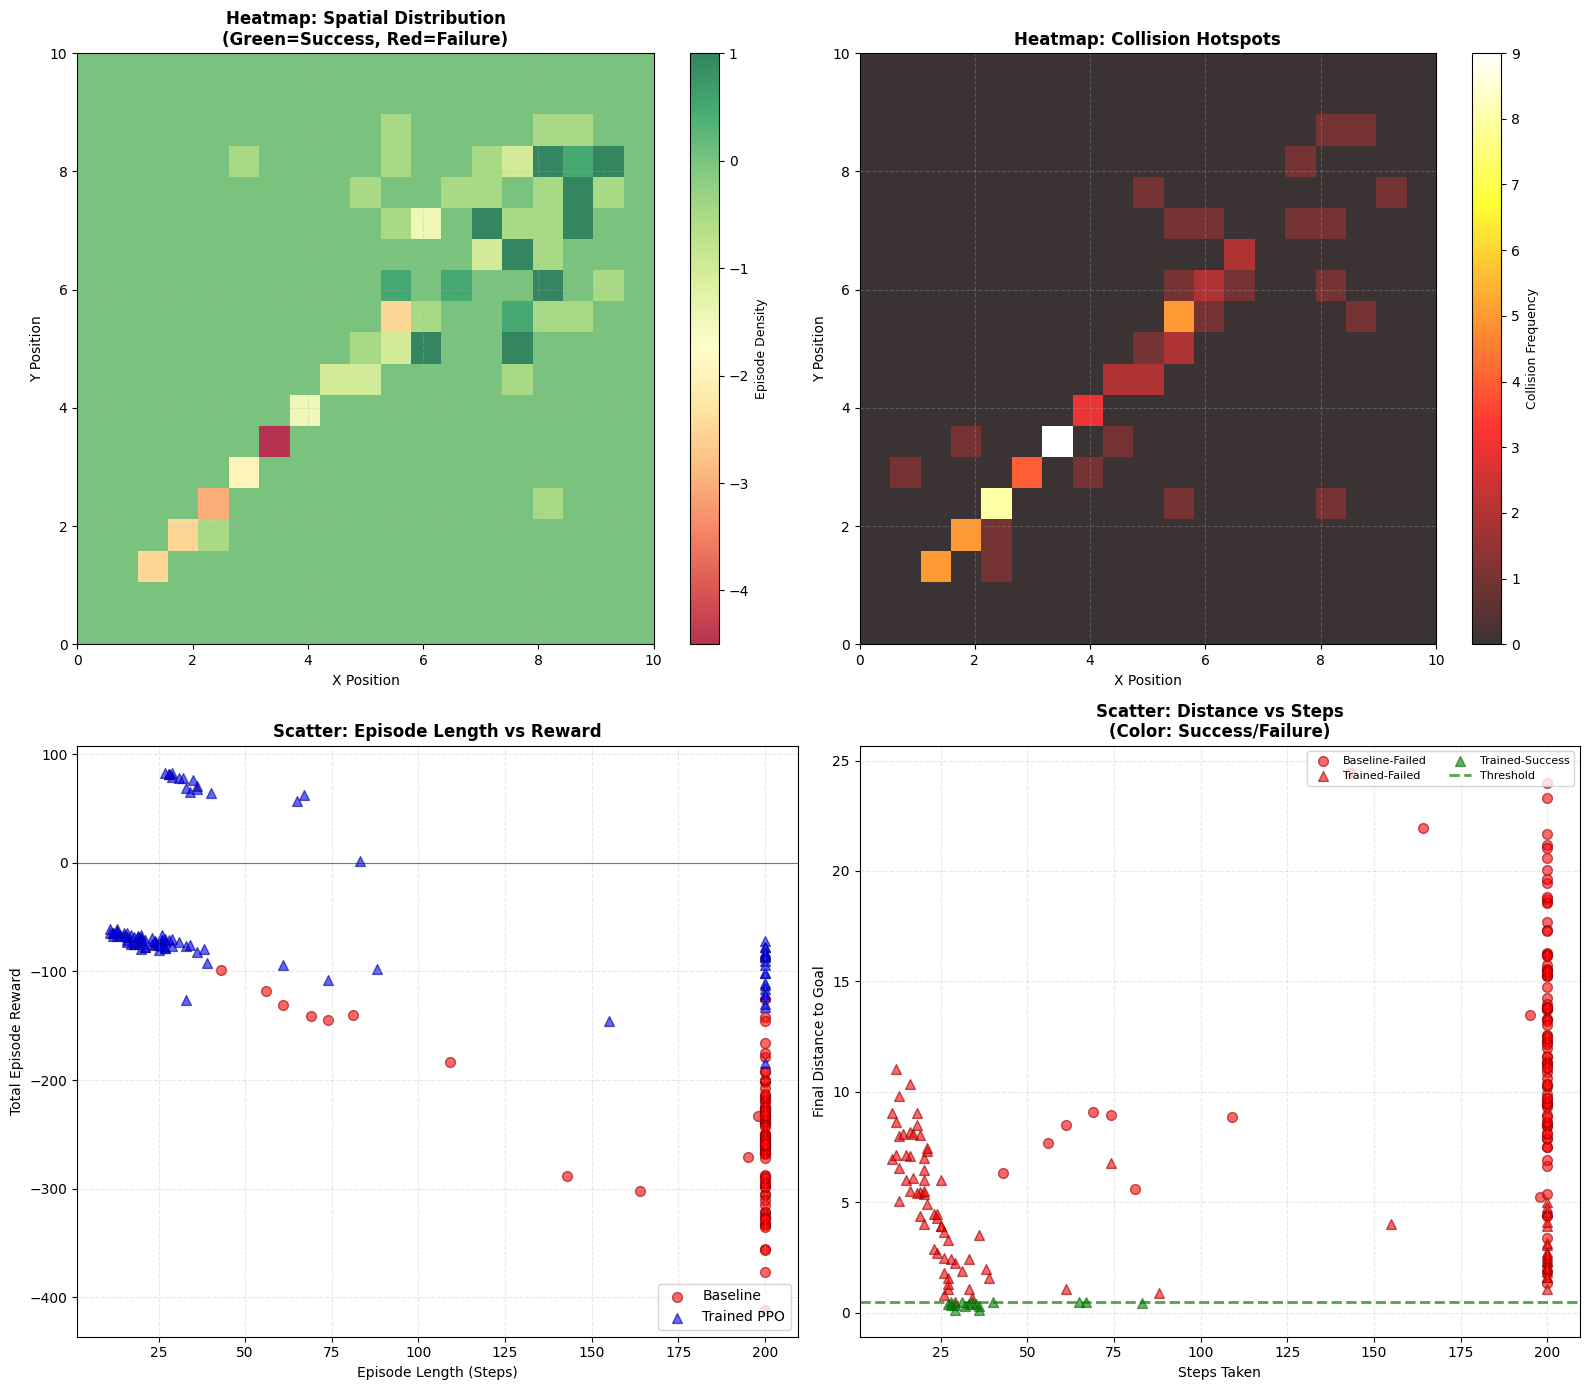


DETAILED STATISTICS

Baseline: 8/100 collisions, 0/100 success
Trained: 64/100 collisions, 16/100 success

ADDITIONAL VISUALIZATIONS COMPLETE


In [ ]:
# Additional Data Analytics: Heatmaps and Scatter Plots
print("\n" + "="*80)
print("ADDITIONAL VISUALIZATIONS: HEATMAPS AND SCATTER PLOTS")
print("="*80)

def collect_episode_data(env, agent_model, num_episodes=100):
    data = {'final_positions': [], 'collision_positions': [], 'episode_lengths': [], 'rewards': [], 'final_distances': [], 'success': []}
    for ep in range(num_episodes):
        obs, info = env.reset()
        done, steps, episode_reward, collided, collision_pos = False, 0, 0, False, None
        while not done and steps < env.max_steps:
            action = env.action_space.sample() if agent_model is None else agent_model.predict(obs, deterministic=True)[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            steps += 1
            if not collided:
                for obstacle in env.obstacles:
                    if np.linalg.norm(env.spacecraft_pos - obstacle) < 0.5:
                        collided, collision_pos = True, env.spacecraft_pos.copy()
                        break
        final_dist = np.linalg.norm(env.spacecraft_pos - env.goal_pos)
        data['final_positions'].append(env.spacecraft_pos.copy())
        data['collision_positions'].append(collision_pos if collided else None)
        data['episode_lengths'].append(steps)
        data['rewards'].append(episode_reward)
        data['final_distances'].append(final_dist)
        data['success'].append(final_dist < 0.5)
    return data

eval_env = SpacecraftEnv(num_obstacles=5)
baseline_data = collect_episode_data(eval_env, None, 100)
trained_data = collect_episode_data(eval_env, model, 100)

fig = plt.figure(figsize=(16, 14))
grid_size, x_edges, y_edges = 20, np.linspace(0, eval_env.space_size, 20), np.linspace(0, eval_env.space_size, 20)

ax1 = plt.subplot(2, 2, 1)
trained_success = np.array([p for p, s in zip(trained_data['final_positions'], trained_data['success']) if s])
trained_fail = np.array([p for p, s in zip(trained_data['final_positions'], trained_data['success']) if not s])
heatmap_data = np.zeros((grid_size-1, grid_size-1))
if len(trained_success) > 0:
    heatmap_data += np.histogram2d(trained_success[:, 0], trained_success[:, 1], bins=[x_edges, y_edges])[0]
if len(trained_fail) > 0:
    heatmap_data -= np.histogram2d(trained_fail[:, 0], trained_fail[:, 1], bins=[x_edges, y_edges])[0] * 0.5
im1 = ax1.imshow(heatmap_data.T, origin='lower', extent=[0, eval_env.space_size, 0, eval_env.space_size], cmap='RdYlGn', aspect='auto', alpha=0.8)
ax1.set_title('Heatmap: Spatial Distribution\n(Green=Success, Red=Failure)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X Position'); ax1.set_ylabel('Y Position'); ax1.grid(True, alpha=0.3, linestyle='--')
plt.colorbar(im1, ax=ax1).set_label('Episode Density', fontsize=9)

ax2 = plt.subplot(2, 2, 2)
all_collisions = [p for p in baseline_data['collision_positions'] + trained_data['collision_positions'] if p is not None]
if len(all_collisions) > 0:
    all_collisions = np.array(all_collisions)
    collision_hist = np.histogram2d(all_collisions[:, 0], all_collisions[:, 1], bins=[x_edges, y_edges])[0]
    im2 = ax2.imshow(collision_hist.T, origin='lower', extent=[0, eval_env.space_size, 0, eval_env.space_size], cmap='hot', aspect='auto', alpha=0.8)
    plt.colorbar(im2, ax=ax2).set_label('Collision Frequency', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No collisions', ha='center', va='center', transform=ax2.transAxes, fontsize=12)
ax2.set_title('Heatmap: Collision Hotspots', fontsize=12, fontweight='bold')
ax2.set_xlabel('X Position'); ax2.set_ylabel('Y Position'); ax2.grid(True, alpha=0.3, linestyle='--')

ax3 = plt.subplot(2, 2, 3)
ax3.scatter(baseline_data['episode_lengths'], baseline_data['rewards'], alpha=0.6, s=50, c='red', marker='o', label='Baseline', edgecolors='darkred')
ax3.scatter(trained_data['episode_lengths'], trained_data['rewards'], alpha=0.6, s=50, c='blue', marker='^', label='Trained PPO', edgecolors='darkblue')
ax3.set_xlabel('Episode Length (Steps)'); ax3.set_ylabel('Total Episode Reward')
ax3.set_title('Scatter: Episode Length vs Reward', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right'); ax3.grid(True, alpha=0.3, linestyle='--')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

ax4 = plt.subplot(2, 2, 4)
for data, name, marker in [(baseline_data, 'Baseline', 'o'), (trained_data, 'Trained', '^')]:
    success_mask = np.array(data['success'])
    fail_dist, fail_steps = np.array(data['final_distances'])[~success_mask], np.array(data['episode_lengths'])[~success_mask]
    if len(fail_dist) > 0:
        ax4.scatter(fail_steps, fail_dist, alpha=0.6, s=50, c='red', marker=marker, edgecolors='darkred', label=f'{name}-Failed')
    succ_dist, succ_steps = np.array(data['final_distances'])[success_mask], np.array(data['episode_lengths'])[success_mask]
    if len(succ_dist) > 0:
        ax4.scatter(succ_steps, succ_dist, alpha=0.6, s=50, c='green', marker=marker, edgecolors='darkgreen', label=f'{name}-Success')
ax4.axhline(y=0.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Threshold')
ax4.set_xlabel('Steps Taken'); ax4.set_ylabel('Final Distance to Goal')
ax4.set_title('Scatter: Distance vs Steps\n(Color: Success/Failure)', fontsize=12, fontweight='bold')
ax4.legend(loc='upper right', fontsize=8, ncol=2); ax4.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DETAILED STATISTICS")
print("="*80)
print(f"\nBaseline: {sum(1 for x in baseline_data['collision_positions'] if x is not None)}/100 collisions, {sum(baseline_data['success'])}/100 success")
print(f"Trained: {sum(1 for x in trained_data['collision_positions'] if x is not None)}/100 collisions, {sum(trained_data['success'])}/100 success")
print("\n" + "="*80)
print("ADDITIONAL VISUALIZATIONS COMPLETE")
print("="*80)